In [1]:
 # option for size of picture output 
set_plot_dimensions <- function(width_choice=9, height_choice=5, res_choice=200) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice, repr.plot.res=res_choice)
        }
set_plot_dimensions()

**Material used for this lecture**

* Kooijman, S. A. L. M., & Bedaux, J. J. M. (1996). Analysis of toxicity tests on Daphnia survival and reproduction. Water Research, 30(7), 1711-1723.
* Nyman, A.-M., Schirmer, K., Ashauer, R., (2012) Toxicokinetic-toxicodynamic modelling of survival of Gammarus pulex in multiple pulse exposures to propiconazole: model assumptions, calibration data requirements and predictive power, Ecotoxicology, (21), 1828-1840.
* Baudrot, V., & Charles, S. (2019). Recommendations to address uncertainties in environmental risk assessment using toxicokinetic-toxicodynamic models. Scientific reports, 9(1), 11432.

In [2]:
library("ggplot2")
library("coda")
library("rjags")

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



# Survival analysis

## Survival function

The survival function is the probability that death of an individual happens after a specified
time $t$, or that the individual under consideration will survive beyond this specified time.

Probability to be alive at age $t$ is:

$$
\mathbb{P}(T \geq t)
$$

* $T$ random variable denoting the time of death
* $t$ the time

We denote $S$ the survival function:

$$
S(t) = \mathbb{P}(T \geq t)
$$

* *Nobody comes back to life after death* = the survival function must be non-increasing: $S(u) \leq S(t)$ if $u \geq t$.

Survival analysis can be used in many other domain than biology, but we usually assume that $S(t=0) = 1$ and $S(t \rightarrow \infty) = 0$.

We denote $F(t)$, called the **lifetime distribution**, is the probability to be dead at time $t$:
$$
F(t) = \mathbb{P}(T \leq t) = 1- \mathbb{P}(T \geq t) = 1- S(t)
$$

by definition of a probability, we have: $\mathbb{P}(T \leq t) + \mathbb{P}(T > t) = 1$

**Visualize an example**

Let assume an exponential law of mortality with mean of 5 years. In R, we write this like:

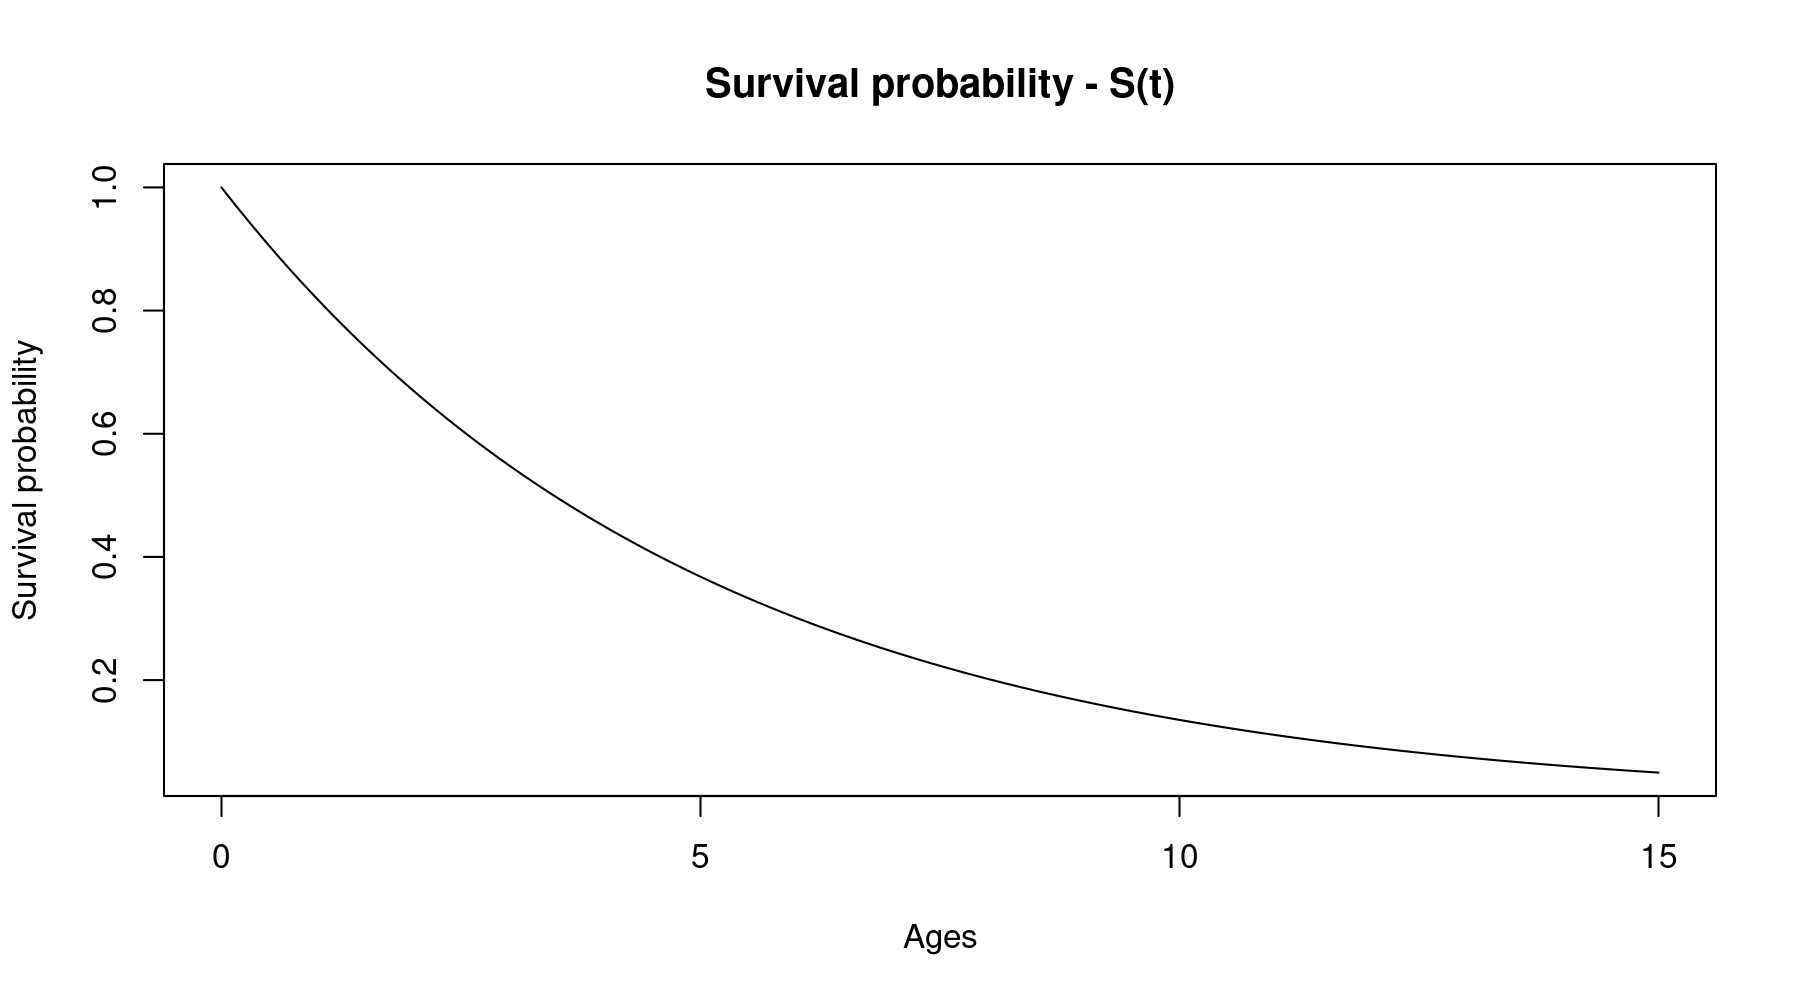

In [3]:
ages = seq(0, 15, by = 0.01)
lifetime = pexp(ages, rate = 1/5)
survival = 1-lifetime
plot(ages, survival, xlab = "Ages", ylab = "Survival probability", main = "Survival probability - S(t)", type = "l")

### Density of mortality event

The probability to be dead at time $t$ is:

$$
F(t) = \mathbb{P}(T \leq t) = \int_0^t \mathbb{P}(T = \tau) d\tau = \int_0^t f(\tau) d\tau
$$

Therefore, if we note $\mathbb{P}(T = \tau)$ is the rate of death (per unit of time) that we denoted $f(\tau)=\mathbb{P}(T = \tau)$.

It follows:

$$
S(t) = 1 - F(t) = 1- \int_0^t f(\tau) d\tau = \int_t^\infty f(\tau) d\tau
$$

* $f(\tau)$: density of mortality event, or mortality event density function
* $s(\tau)$: density of survival event, or survival event density function

$$
s(t) = \frac{dS(t)}{dt} = \frac{d(1- F(t))}{dt} = - f(t)
$$

To be clear:

* $S(t)$: probability to be alive when observation at time $t$, we are going to die latter, just after or long time after.
* $F(t)$: probability to be dead when observation at time $t$, we may have die at time $t$ or long time before (up to $t=0$).
* $f(t)$: density function to be dead at the instantaneous time $t$.
* $s(t)$: less common to use: probability of still being alive at this instantaneous moment.

Important: $f(t)$ is not the probability to die at time $t$, which is the hazard function we are going to see just after. This hazard function, the probability to die at time $t$, suppose the condition of being alive just before that time $t$, it's a conditional probability.


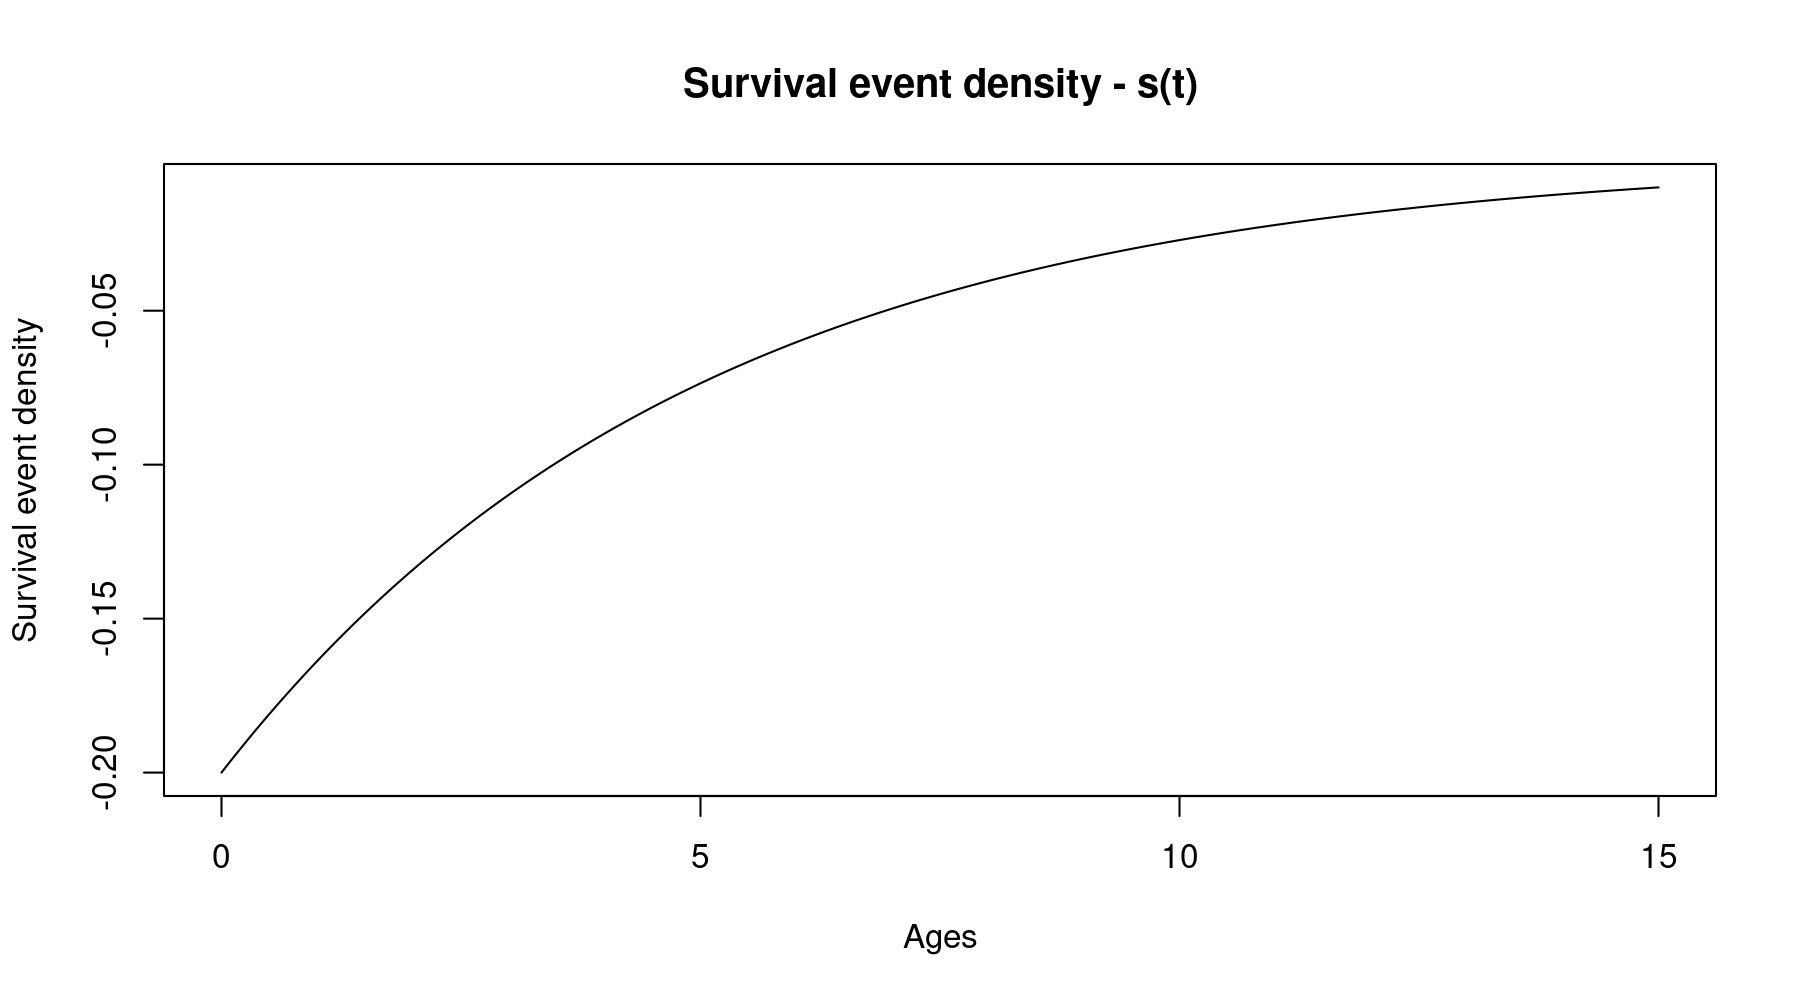

In [4]:
death_event = dexp(ages, rate = 1/5)
survival_event = -death_event
plot(ages, survival_event, xlab = "Ages", ylab = "Survival event density", main = "Survival event density - s(t)", type = "l")

#### Note on Probability and Density function in R

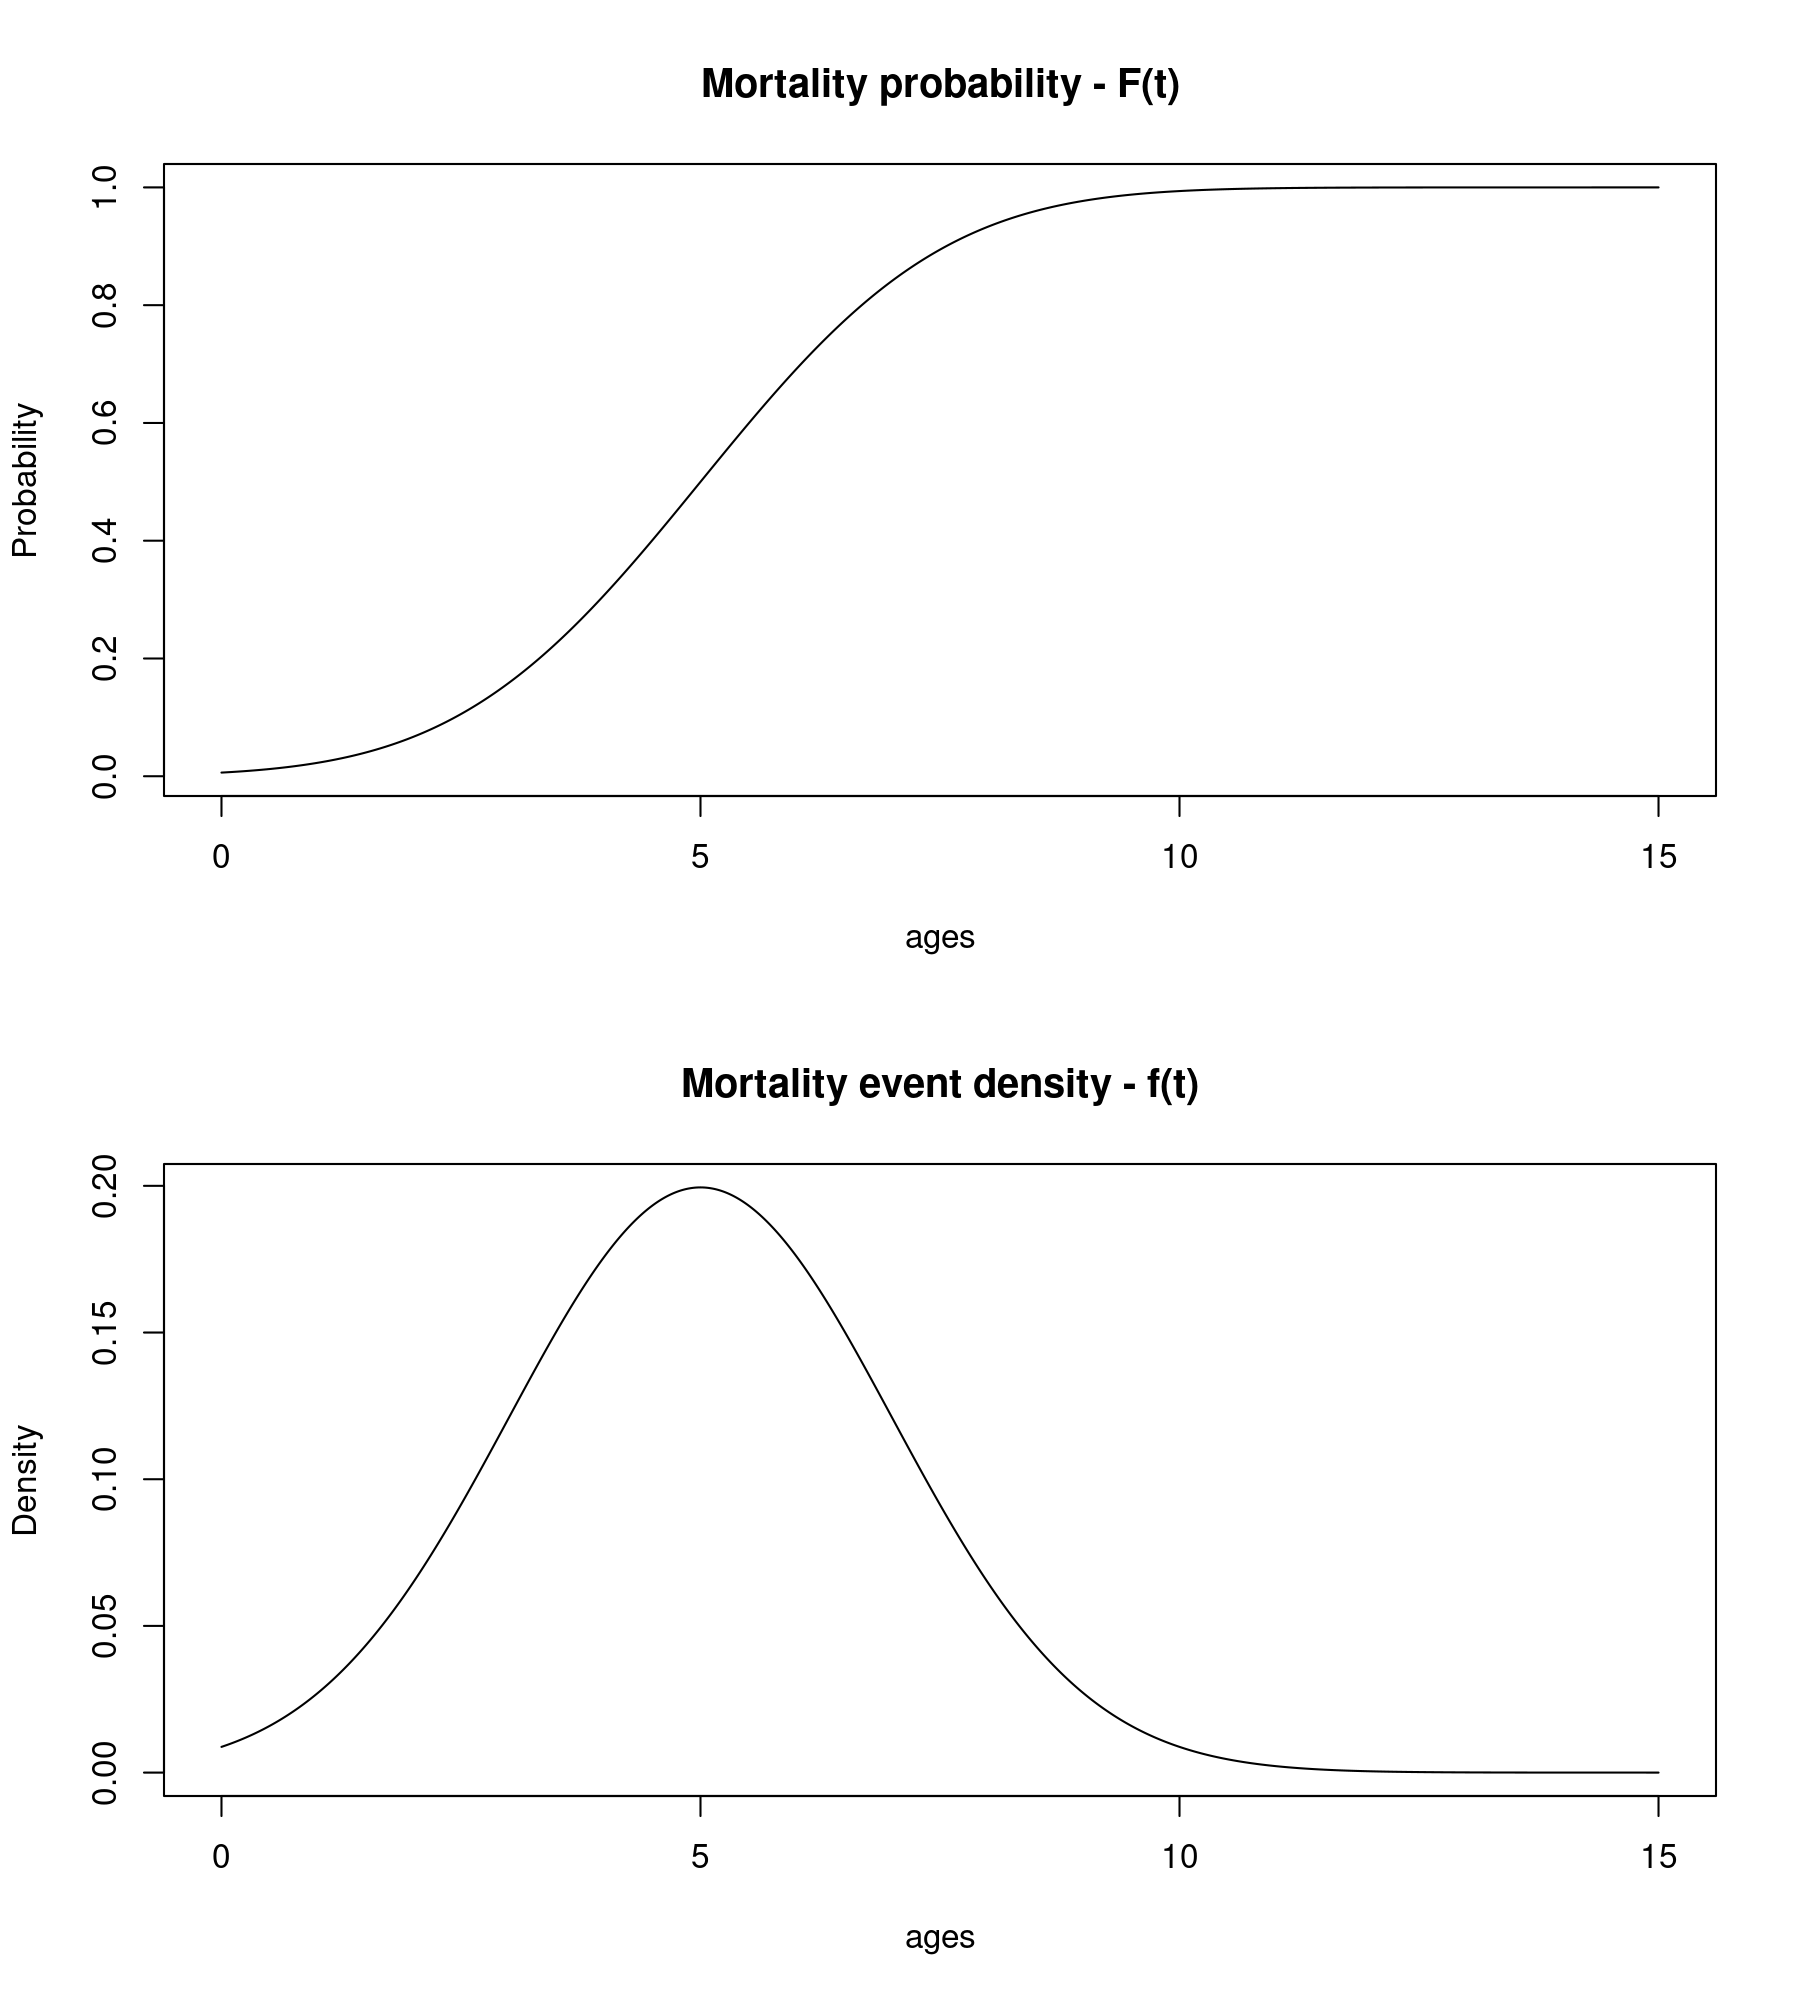

In [5]:
# Normal distribution
set_plot_dimensions(9,10)
par(mfrow = c(2,1))
plot(ages, pnorm(ages, mean = 5, sd = 2),
      ylab = "Probability", type = "l", main = "Mortality probability - F(t)")
plot(ages, dnorm(ages, mean = 5, sd = 2),
      ylab = "Density", type = "l", main = "Mortality event density - f(t)")

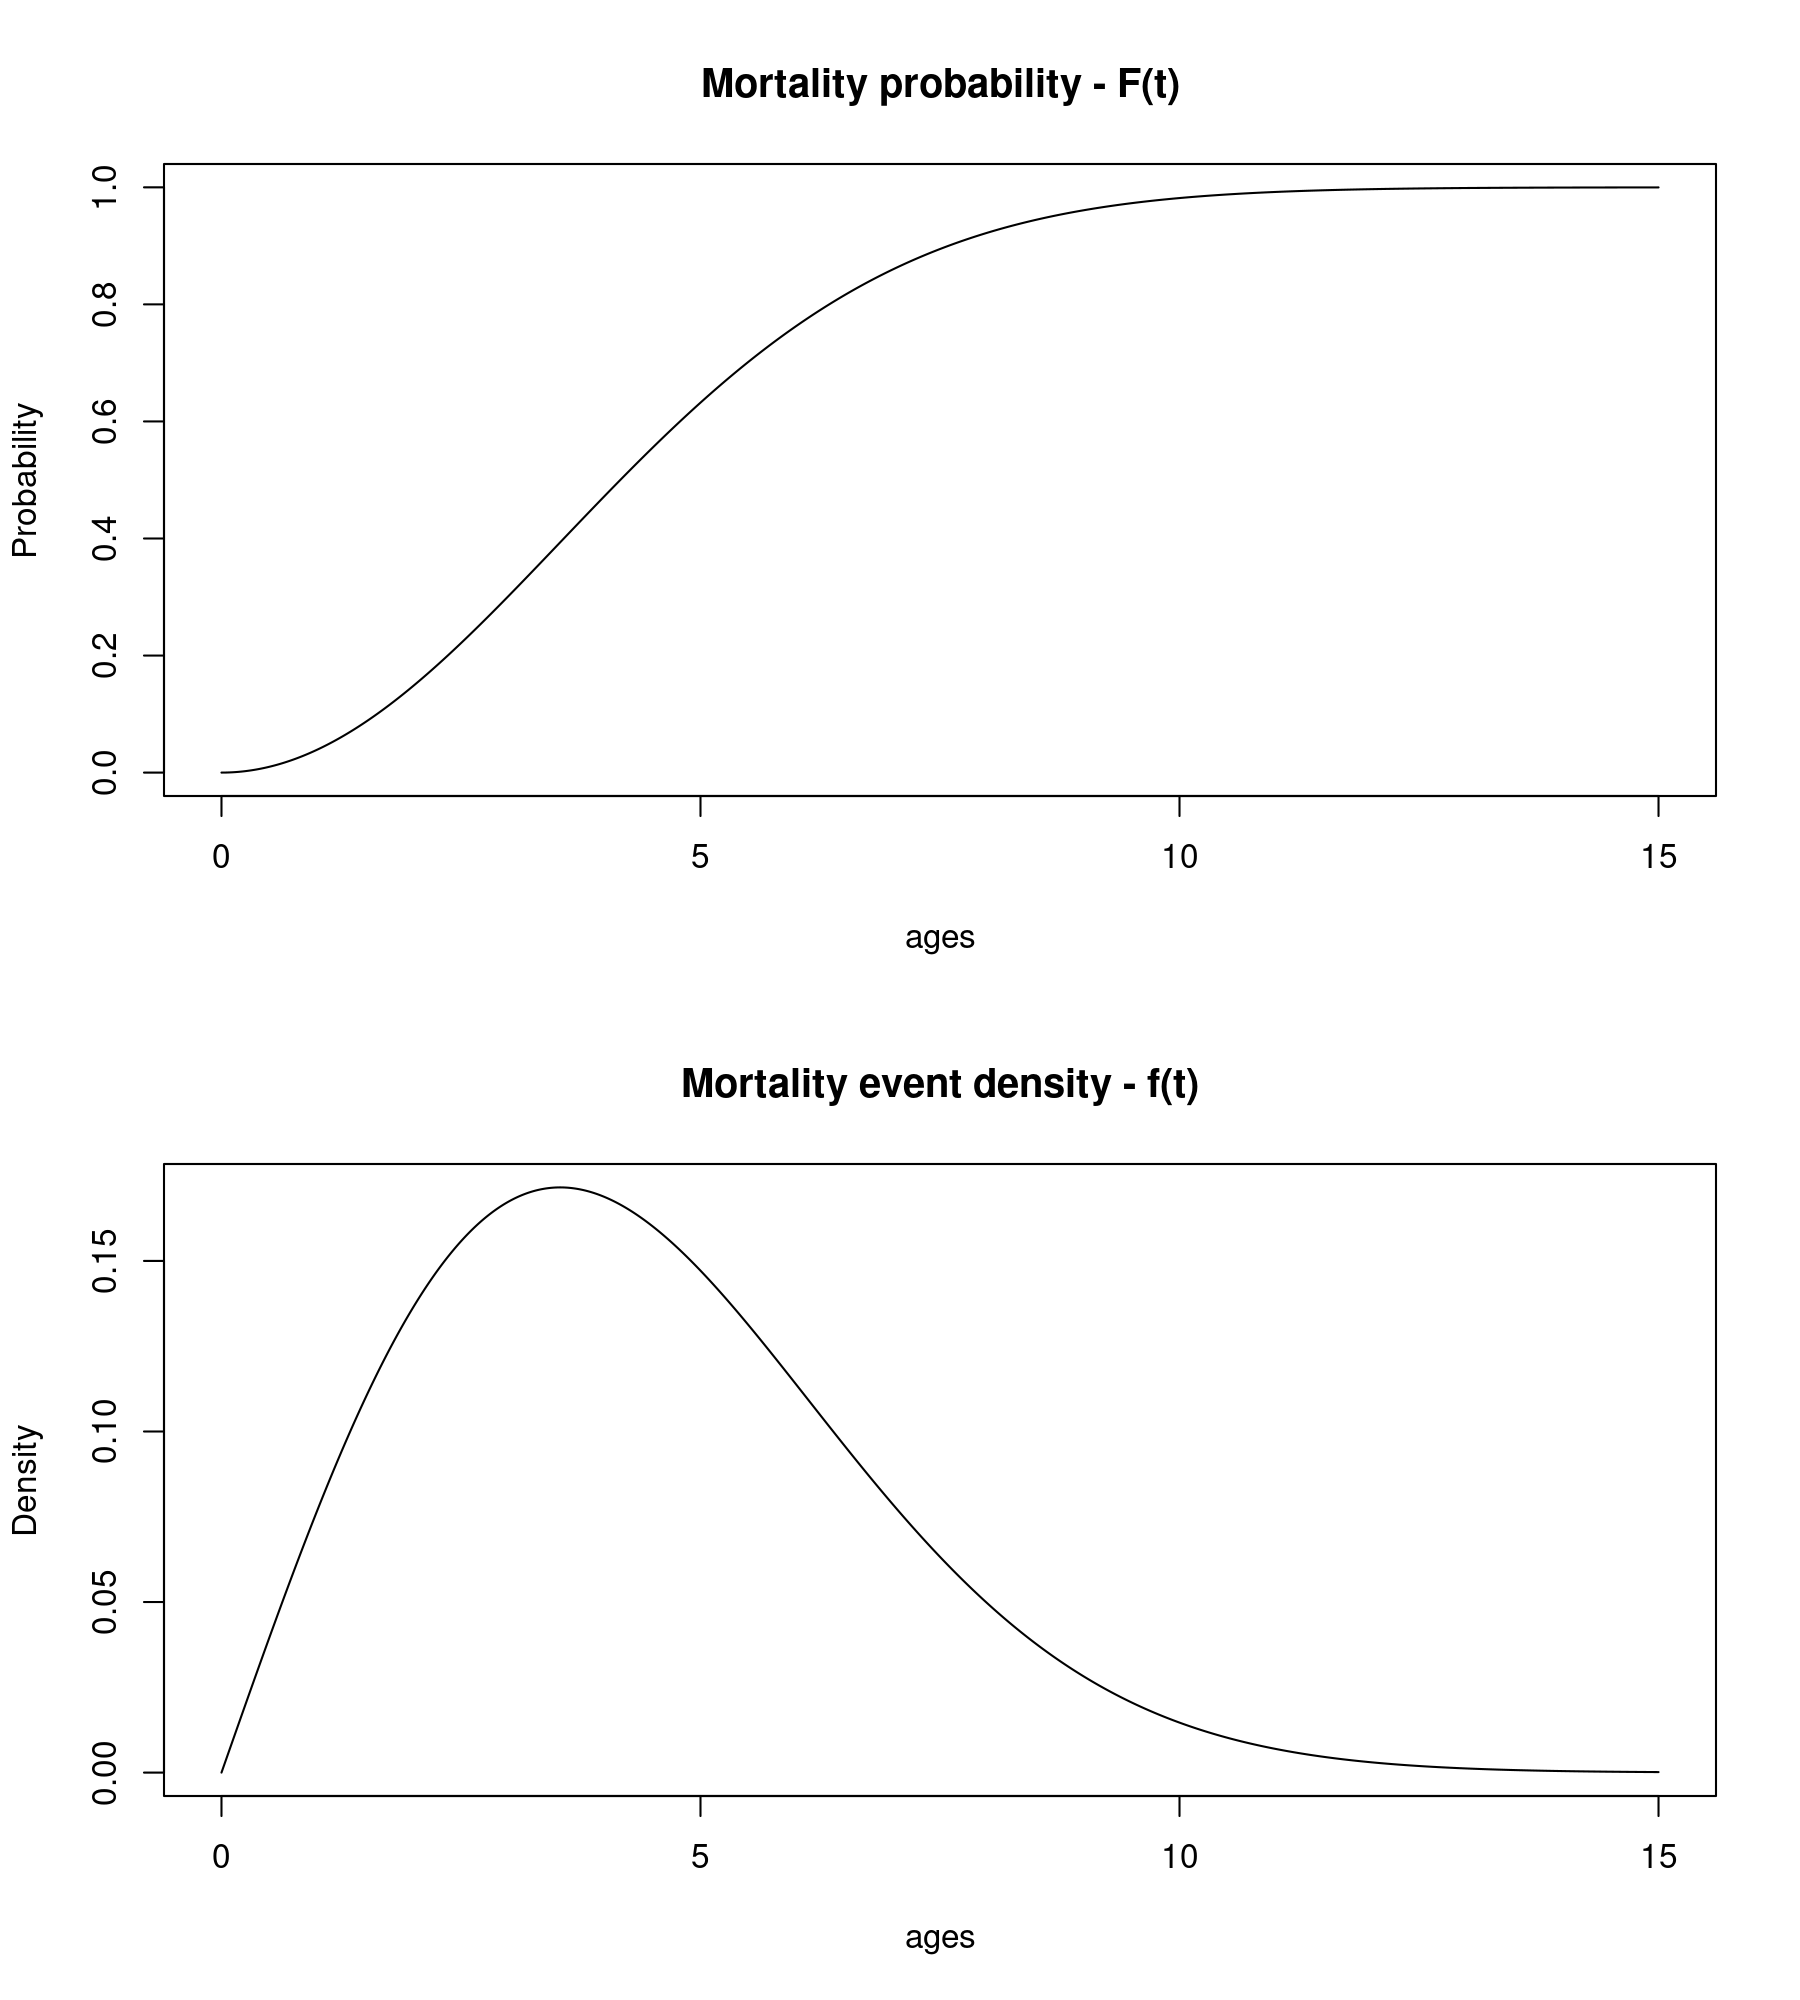

In [6]:
# Weibull distribution
par(mfrow = c(2,1))
plot(ages, pweibull(ages, shape = 2, scale = 5),
     ylab = "Probability", type = "l", main = "Mortality probability - F(t)")
plot(ages, dweibull(ages, shape = 2, scale = 5),
     ylab = "Density", type = "l", main = "Mortality event density - f(t)")

> **QUESTION**
>
> (1) - Test for other classical distribution of survival analysis Log-logistic, Gamma and Poisson
>
> (2) - What is different with a Poisson distribution?

In [7]:
# REPLY (1) and (2) HERE


### Hazard function

The hazard function, denoted $h$, is defined as the mortality rate at time $t$ conditional on survival until time $t$ or later.

* It is different to $f(t)$ which is the mortality event at time $t$.

$$
f(t) dt = \mathbb{P}(t \leq T < t + dt)
$$

while $h(t)$ is:

$$
h(t) dt = \mathbb{P}(t \leq T < t + dt \vert T > t)
$$

and therefore, using the limits theory:

$$
h(t) = \lim\limits_{dt \rightarrow 0} \frac{\mathbb{P}(t \leq T < t + dt \vert T > t)}{dt}
$$

Remember the Bayes Theorem:

$$
 \mathbb{P}(A \vert B) = \frac{ \mathbb{P}(B \vert A)  \mathbb{P}(A)}{ \mathbb{P}(B)}
$$

Giving:

$$
\begin{align}
h(t) &= \lim\limits_{dt \rightarrow 0} \frac{1}{dt} \times \mathbb{P}(t \leq T < t + dt \vert T > t) \\[3mm]
     &= \lim\limits_{dt \rightarrow 0} \frac{1}{dt} \times
     \frac{\mathbb{P}(T > t \vert t \leq T < t + dt ) \mathbb{P}(t \leq T < t + dt )}{\mathbb{P}(T > t)}
\end{align}
$$

You note that, with the law $\mathbb{P}(A \vert (A \cap B)) = 1$, we have:
$$
\mathbb{P}(T > t \vert t \leq T < t + dt) = \mathbb{P}(T > t \vert ( t \leq T \cap  T  < t + dt)) = 1
$$

And finally :

$$
h(t) = \lim\limits_{dt \rightarrow 0} \frac{1}{dt} \frac{\mathbb{P}(t \leq T < t + dt )}{\mathbb{P}(T > t)} = \frac{f(t)}{S(t)}
$$

The hazard rate is also called *failure rate* and is easy to understand, for instance some classical failure rate:

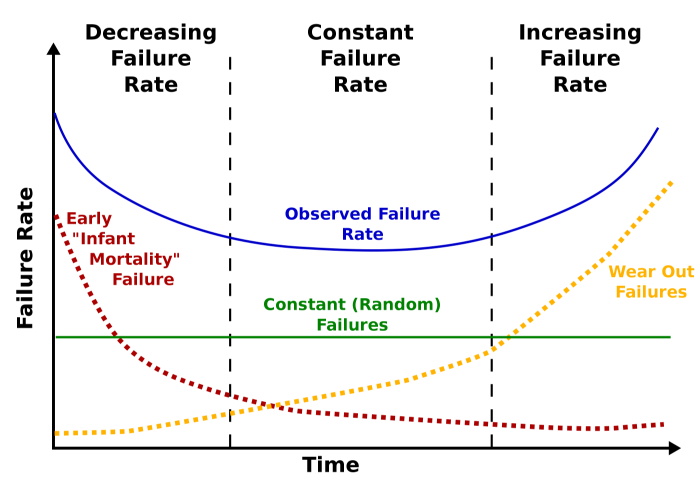

### Cumulative Hazard function

Starting with the definition of the hazard function and with the definition of density of survival $s(t)=-f(t)=dS(t)/dt)$, we obtain:

$$
h(t) = \frac{f(t)}{S(t)} = \frac{-dS(t)/dt}{S(t)}
$$

The cuulative Hazard Function is given by:

$$
H(t) = \int_0^t h(\tau) d\tau = \int_0^t \frac{-dS(\tau)/d\tau}{S(\tau)} d\tau = - \ln\left( S(t)\right) + cst
$$

Note: a primitive of $u'/u$ is $\ln(u)$.

Finally:

$$
S(t) = \exp \left( - \int_0^t h(\tau) d \tau \right)
$$


## Exercise 1: Log-logistic distribution

### Survival function

The log-logistic distribution has a non-monotonic hazard function which makes it suitable for modelling some sets of survival data.

$$
F(t) = \frac{1}{1+(t/\alpha)^{-\beta}}
$$

> **QUESTION**
>
> (3) - What is $S(t)$? Make the simplification.
>
> (4) - Plot $S(t)$. Assume $\alpha=5$ and $\beta=4$. The range of $t$ is $[0,10]$.

In [8]:
# REPLY (3) and (4) HERE


<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
    
  ```R
    set_plot_dimensions()
    # Plot S(t)
    survival = function(t,alpha,beta){
        return(1/(1+(t/alpha)^beta))
    }
    t = seq(0,10,by= 0.1)
    plot(t, survival(t, 5, 4), type ="l", main = "Survival function") 
  ```
</details>

### Hazard function

Using definition introduced previously:

$$
h(t) = \frac{-dS(t)/dt}{S(t)}
$$

The derivative of $S(t)$ as defined previously is:

$$
\frac{dS(t)}{dt} = \frac{\beta}{\alpha} \left( \frac{t}{\alpha} \right)^{\beta-1} \times \frac{1}{\left(1+(\frac{t}{\alpha})^\beta \right)^2} 
$$

$$
h(t) = \frac{-\frac{\beta}{\alpha} \left( \frac{t}{\alpha} \right)^{\beta-1} \times \frac{1}{\left(1+(\frac{t}{\alpha})^\beta \right)^2} }{\frac{1}{1+(t/\alpha)^{\beta}}}
$$

After simplification, we obtain:

$$
h(t) = \frac{\beta}{t} \left( \frac{t}{\alpha} \right)^{\beta-1} \times \frac{1}{1+(\frac{t}{\alpha})^\beta} 
$$

> **QUESTION**
>
> (5) - plot the derivative of the survival $s(t)=dS(t)/dt$ using the same parameterization
>
> (6) - Plot the hazard function $h(t)$
>
> (7) - Compare the two function with the survival function

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
    
  ```R
    # Plot s(t)
    survival_event = function(t,alpha,beta){
        p1 = beta / alpha * (t / alpha)^(beta - 1)
        p2 = 1/(1+(t / alpha)^beta)^2
        return(p1*p2)
    }
    t = seq(0,10,by= 0.1)
    plot(t, survival_event(t, 5, 4), type ="l", main = "Survival event") 
  ```
</details>

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
    
  ```R
    # Plot h(t)
    hazard = function(t,alpha,beta){
        p1 = beta / t * (t / alpha)^(beta - 1)
        p2 = 1/(1+(t / alpha)^beta)
        return(p1*p2)
    }
    t = seq(0,10,by= 0.1)
    plot(t, hazard(t, 5, 4), type ="l", main = "Failure function") 
  ```
</details>

<details>
  <summary>ANSWER</summary>

  **Copy/past the code:**
    
    
  ```R
    # Comparison
    t = seq(0,20,by= 0.1)
    plot(t, survival(t, 5, 4), type ="l", main = "Survival function", col="red")
    lines(t, survival_event(t, 5, 4), type ="l", col = "orange")
    lines(t, hazard(t, 5, 4), type ="l", col = "blue") 
  ```
</details>

> **QUESTION**
>
> (8) - How can you interpret the hazard function in regard to the density surival event?

In [13]:
# REPLY HERE


## Exercise 2: Survival as function of toxicant

In toxicological studies, we want to explore the survival as function of the toxicant rather than time.

The survival function is not a function of time $t$ but of the concentration $x$.

$$
S(x) = \frac{1}{1+(x/\alpha)^{\beta}}
$$

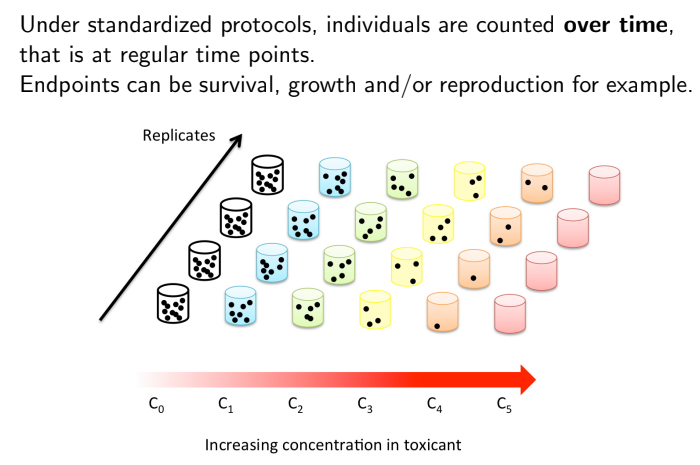

### Data

Data are the number of surviving individual at the end of the experiment.

In [14]:
Nsurvival = unlist(lapply(10*c(6, 4.5, 3, 2, 0.5, 0), function(l) rpois(6, l)))
concentration = unlist(lapply(c(0,53,78,124,232,284), function(c) rep(c, 6)))
Data = data.frame(
    concentration = concentration,
    Nsurvival = Nsurvival
)

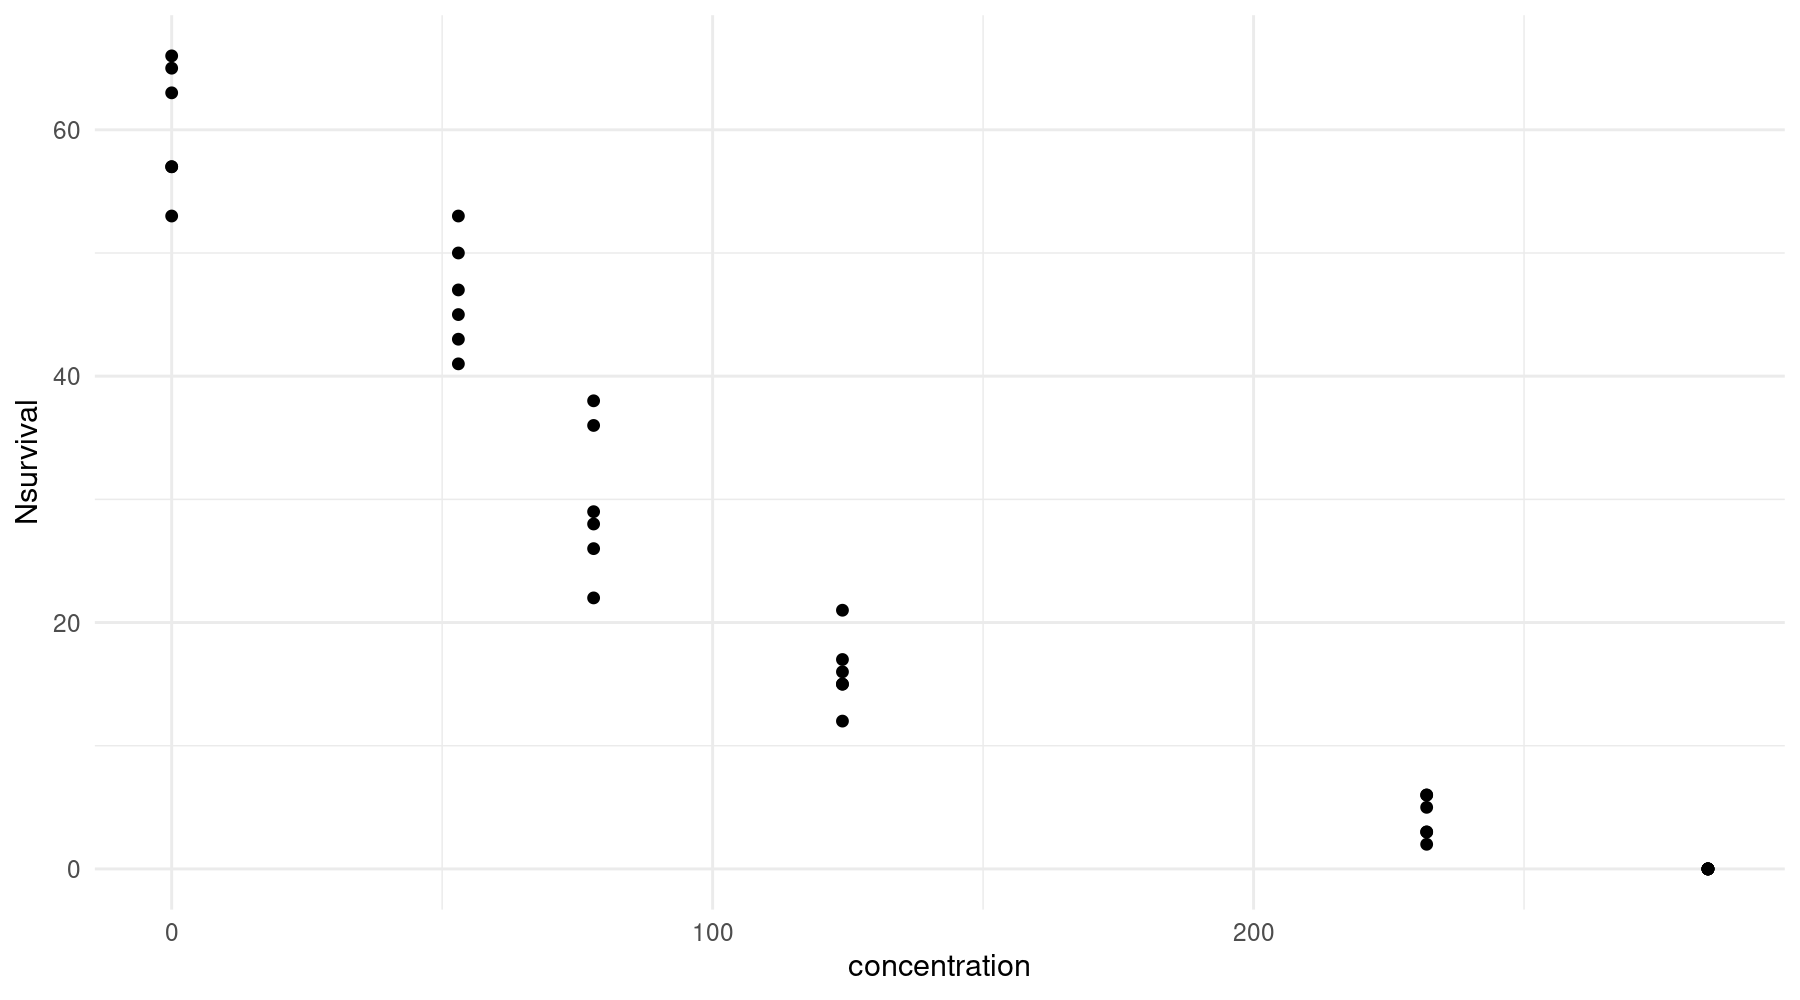

In [15]:
set_plot_dimensions(9,5)
ggplot() + 
    theme_minimal() +
    geom_point(aes(x = concentration, y = Nsurvival))

### Bayesian inference

Here we count the number of survival, which is not directly the propability of survival.

* We denote $N_{survival}$ the random variable counting the number of survival
* We denote $p_{survival}$ the probability of survival 

1. the random part for counting the number of survival following a Poisson law with parameter $\lambda$ which is the mean:
$$
N_{survival} \sim \text{Poisson}(\lambda) 
$$

2. a link function between the parameter of the Poisson function $\lambda$, the prior number of individual $n$ and the survival probability depending on the concentration (dose) $c$, denoted $p_{survival}(c)$:
$$
\lambda = n \times p_{survival}(c)
$$

3. the random part of the probability of survival depending on the dose is then assuming to follow the log-logistic distribution
$$
p_{survival}(c) \sim 1-\text{Log-logistic}(c \vert \alpha,\beta)
$$

#### Choosing Poisson vs Binomial vs Negative Binomial distribution.

For the first step, we could have use a binomial distribution
$$
N_{survival} \sim \text{Binomial}(n, p_{survival}(c)) 
$$

And keeping: $p_{survival}(c) \sim 1-\text{Log-logistic}(c \vert \alpha,\beta)$

So why choosing a Poisson model ?

* The Poisson model is appropriate for modeling discrete counts of events that happen in a fixed interval of space or time and that, theoretically, have no upper bound.

So, Poisson model is highly used in counted data, like for counting individual or species in ecosystem. Demographers may model death rates in geographic areas as the count of deaths divided by person−years.

In our situation, if we now the number of individual at the begining of the experiment, as it is usually the case in standardized protocols starting a fixed and known number of individual, a Binomial model of trial events would have been more appropriate.

There is also the Negative binomial model which is a popular generalization of Poisson regression because it loosens the highly restrictive assumption that the variance is equal to the mean made by the Poisson model. The traditional negative binomial regression model is based on the Poisson-gamma mixture distribution. This model is popular because it models the Poisson heterogeneity with a gamma distribution.

#### Defining priors

A complex task in Bayesian inference is defining priors.

In this model, we need priors for :
* $n$: the number of individuals, therefore something $>0$ and, in our case, smaller than the initial number of individuals.
* $\alpha$: the scale parameters of the log-logistic distribution. The larger the scale parameter, the more spread out the distribution.
* $\beta$: the shape parameters of the log-logistic distribution.

For $n$ parameter, 


### using JAGS

The log-logistic function does not exist in JAGS. So we have to write the equation as a deterministic part.

In [16]:
modelPoisson <- "model
    {
        # Definition of links
        for (i in 1:n_data){
            Nsurvival[i] ~ dpois(lambda[i])
            lambda[i] <- n * psurvival[i]
            psurvival[i] <- 1/(1+(concentration[i]/alpha)^beta)
        }
        # Definition priors        
        n ~ dunif(0, 1000) 
        log10beta ~ dunif(-2,2)
        beta <- pow(10,log10beta)
        log10alpha ~ dunif(1, 3)
        alpha <- pow(10,log10alpha)
        # Generate new data
        for(i in 1:n_sim){
            psurvival_sim[i] <- 1/(1+(concentration_sim[i]/alpha)^beta)
            Nsurvival_sim[i] ~ dpois(n * psurvival_sim[i])
        }
        for(i in 1:n_pred){
            psurvival_pred[i] <- 1/(1+(concentration_pred[i]/alpha)^beta)
            Nsurvival_pred[i] ~ dpois(n * psurvival_pred[i])
        }
    }"
    

In [17]:
simulation = list(
    concentration_sim = unique(Data$concentration),
    concentration_pred = seq(min(Data$concentration), max(Data$concentration), length.out = 100)
    )

In [18]:
data4jags <- list(
    n_data = nrow(Data),
    concentration = Data$concentration,
    Nsurvival = Data$Nsurvival,
    n_sim = length(simulation$concentration_simu),
    concentration_sim = simulation$concentration_simu,
    n_pred = length(simulation$concentration_pred),
    concentration_pred = simulation$concentration_pred
)

In [19]:
ini1 <- list(n = 1, log10alpha = 2, log10beta = -1)
ini2 <- list(n = 500, log10alpha = 1, log10beta = 1)
ini3 <- list(n = 100, log10alpha = 3, log10beta = 0)
ini <- list(ini1, ini2, ini3)

In [20]:
model <- jags.model(
    file = textConnection(modelPoisson),
    data = data4jags,
    inits = ini,
    n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 36
   Unobserved stochastic nodes: 103
   Total graph size: 807

Initializing model



In [21]:
update(model, 5000)

In [22]:
mcmc <- coda.samples(model, c("n", "alpha", "beta", "Nsurvival_pred"), n.iter = 5000)

In [23]:
extract_chain = function(mcmc, key){
    ls_mcmc = lapply(mcmc, function(m){
        matching_columns = grepl(key, colnames(m))
        return(m[,matching_columns])
    })
    matrix_key = do.call("rbind",ls_mcmc)
    return(matrix_key)
}

In [24]:
matrix_mcmc = extract_chain(mcmc, 'Nsurvival_pred')
prediction = apply(matrix_mcmc, 2, quantile, c(0.05,0.5,0.975))

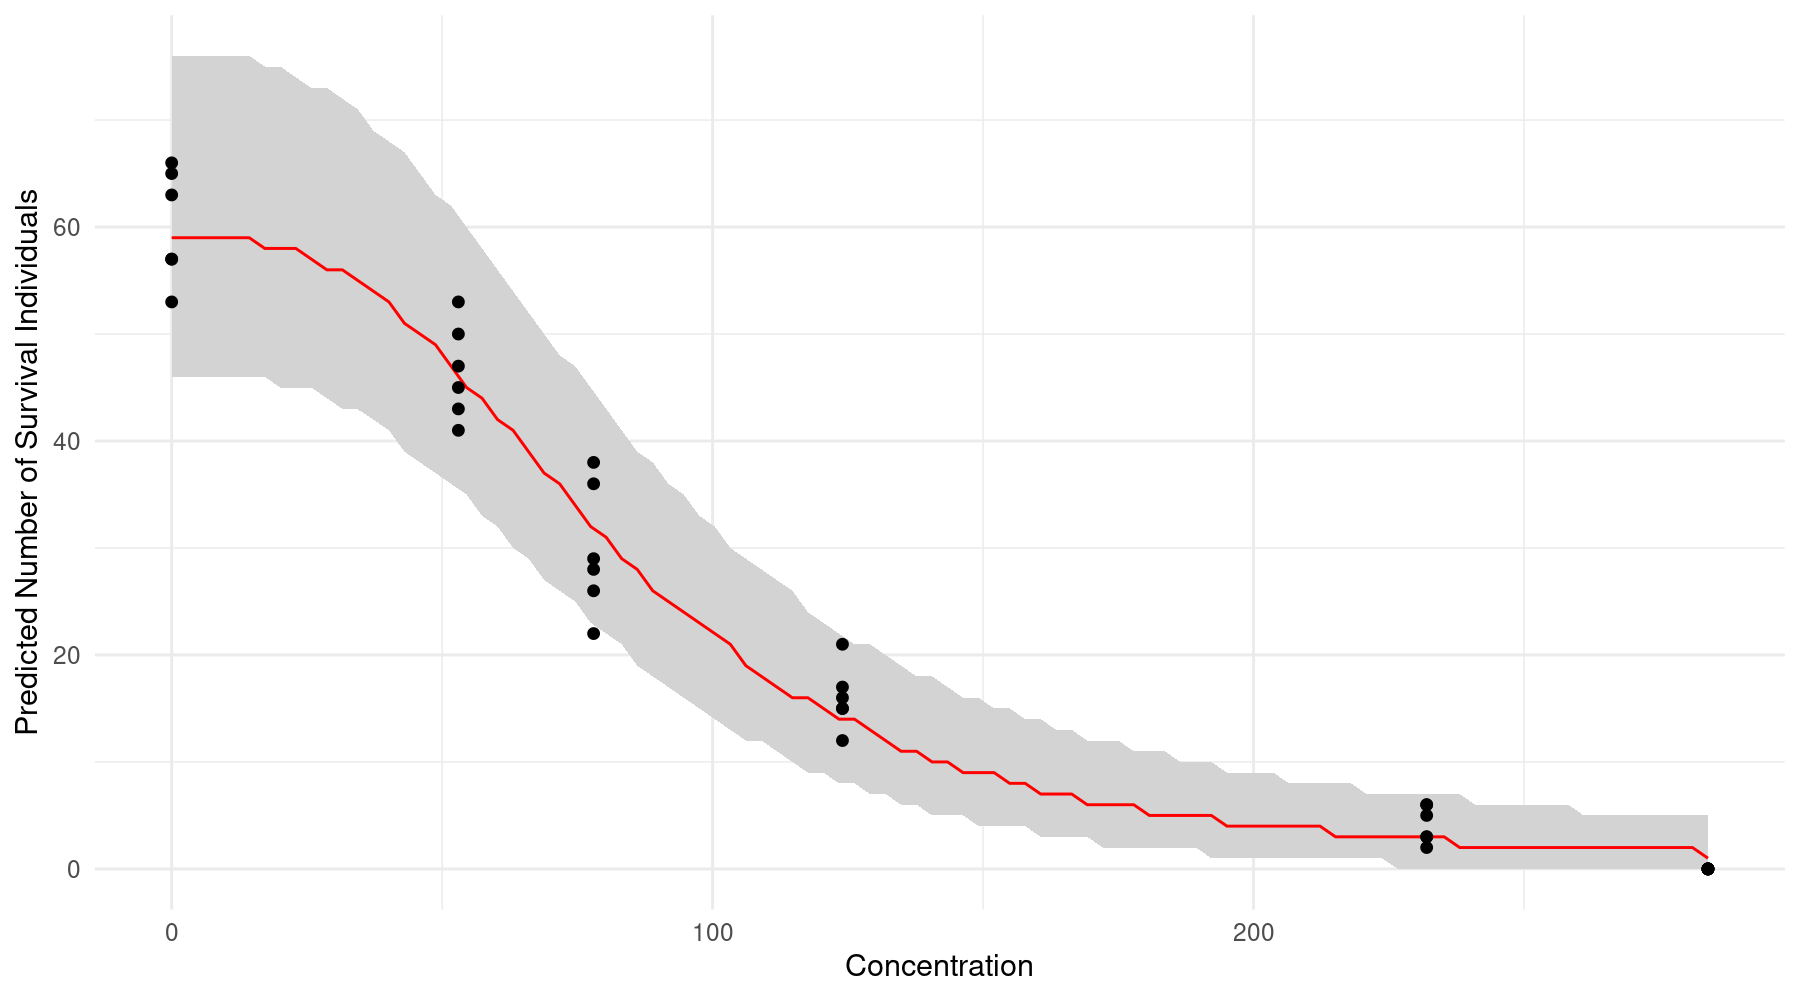

In [25]:
ggplot() + 
    theme_minimal() +
    labs( x = "Concentration", y = "Predicted Number of Survival Individuals") +
    geom_ribbon(aes(x = simulation$concentration_pred, ymin=prediction[1,], ymax=prediction[3,]), fill = "lightgrey") +
    geom_line(aes(x = simulation$concentration_pred, y=prediction[2,]), color = "red") +
    geom_point(aes(x = Data$concentration, y = Data$Nsurvival))
    

## Exercise 3: Survival as function of time and toxicant... a step to TKTD

In the famous article by Kooijman and Bedaux (1996) on *Daphnia magna*, we can see how the sigmoidal curve defined previously evolve wih time.
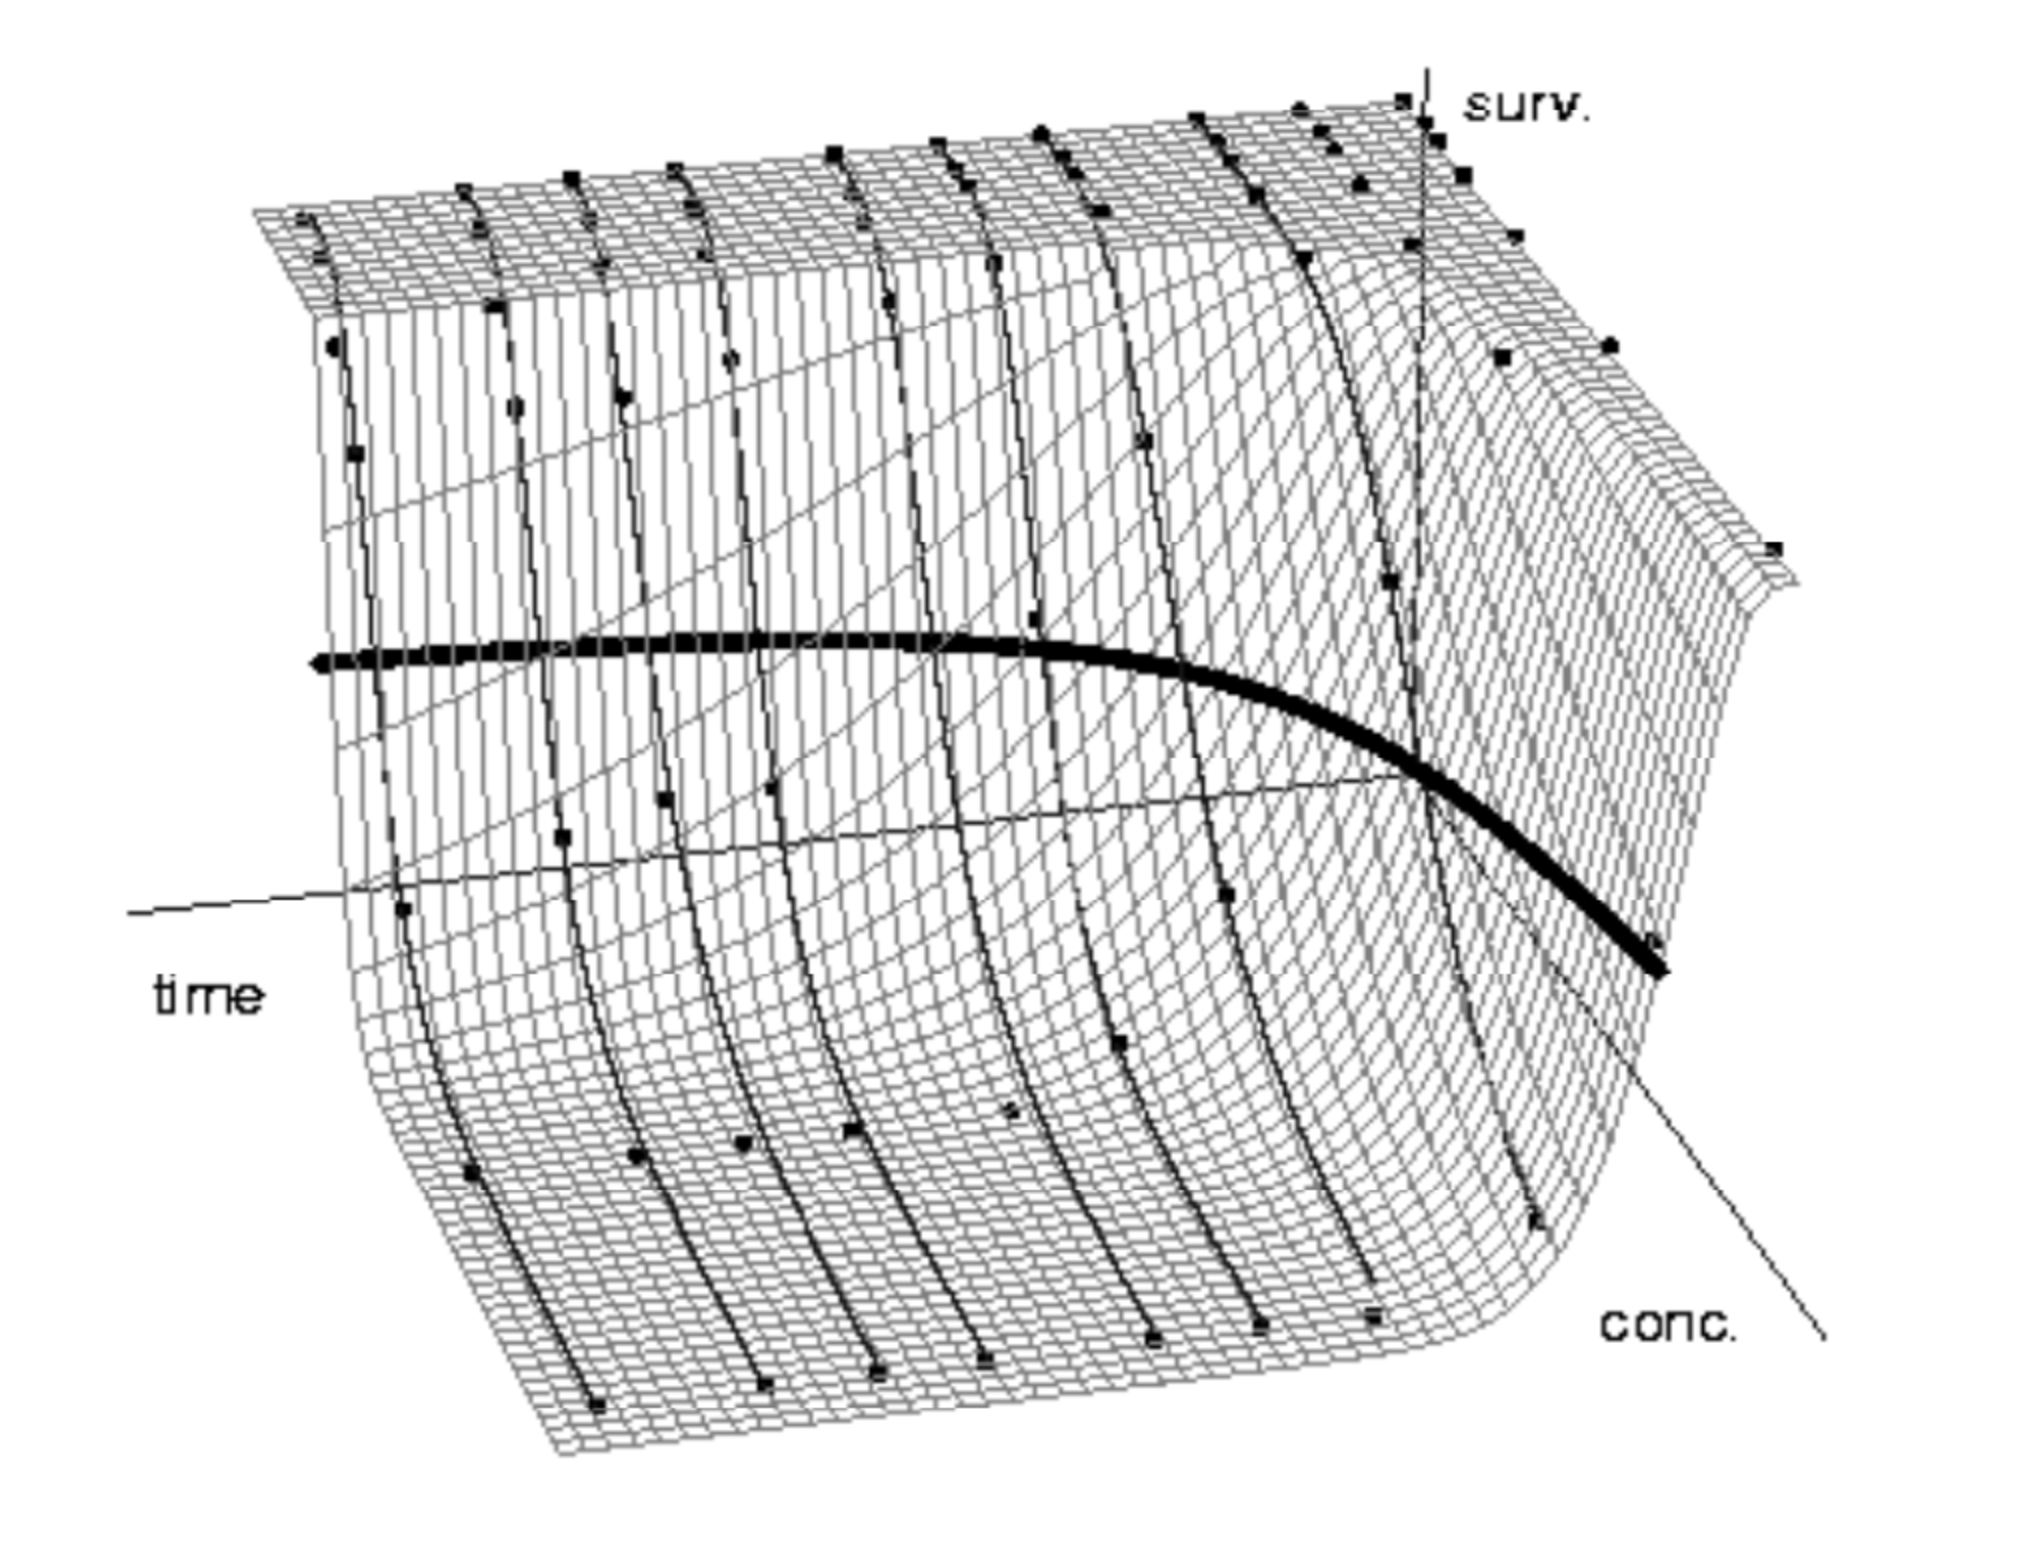

Observation:
* the survival model as a function of concentration are sigmoidal curve whatever the time.
* the plan of lethal concentration given 0.5 survival, the $LC_{50}$ represented by the large black line, decreases exponentially with time.

This second point on $LC_{50}$ is in line with the model in Baudrot and Charles (2019):

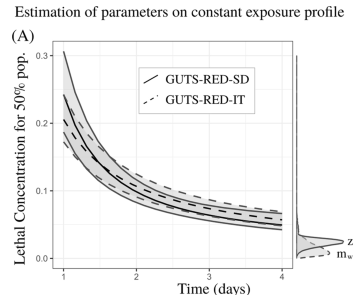

### Overview of the data set


Survival data set (from Nyman, Schirmer and Ashauer, 2012) of chronic laboratory toxicity tests with *Gammarus pulex* freshwater invertebrate exposed to eight concentrations of one fungicide (propiconazole) during four days. Eight concentrations were tested with two replicates of 10 organisms per concentration. Survival is monitored at five time points.

A dataframe with the following four variables:
* `replicate`: A vector of class factor with the replicate code (SC for the control and A1 to G2 for other profiles).
* `conc`: A vector of class numeric with propiconazole concentrations in μ mol.L^{-1}.
* `time`: A vector of class integer with the time points (in days from the beginning of the experiment t = 0).
* `Nsurv`: A vector of class integer with the number of alive individuals at each time point for each concentration and each replicate.


In [26]:
dataGUTS = read.table("data/dataGUTS.csv", sep = ",", header = TRUE)
dataGUTS$concentration = as.factor(dataGUTS$conc)
dataGUTS$time_discret = as.factor(dataGUTS$time)
# write.csv(dataGUTS[, c('conc','time','Nsurv','replicate','Psurv')] , file="data/dataGUTS.csv",  row.names = FALSE)

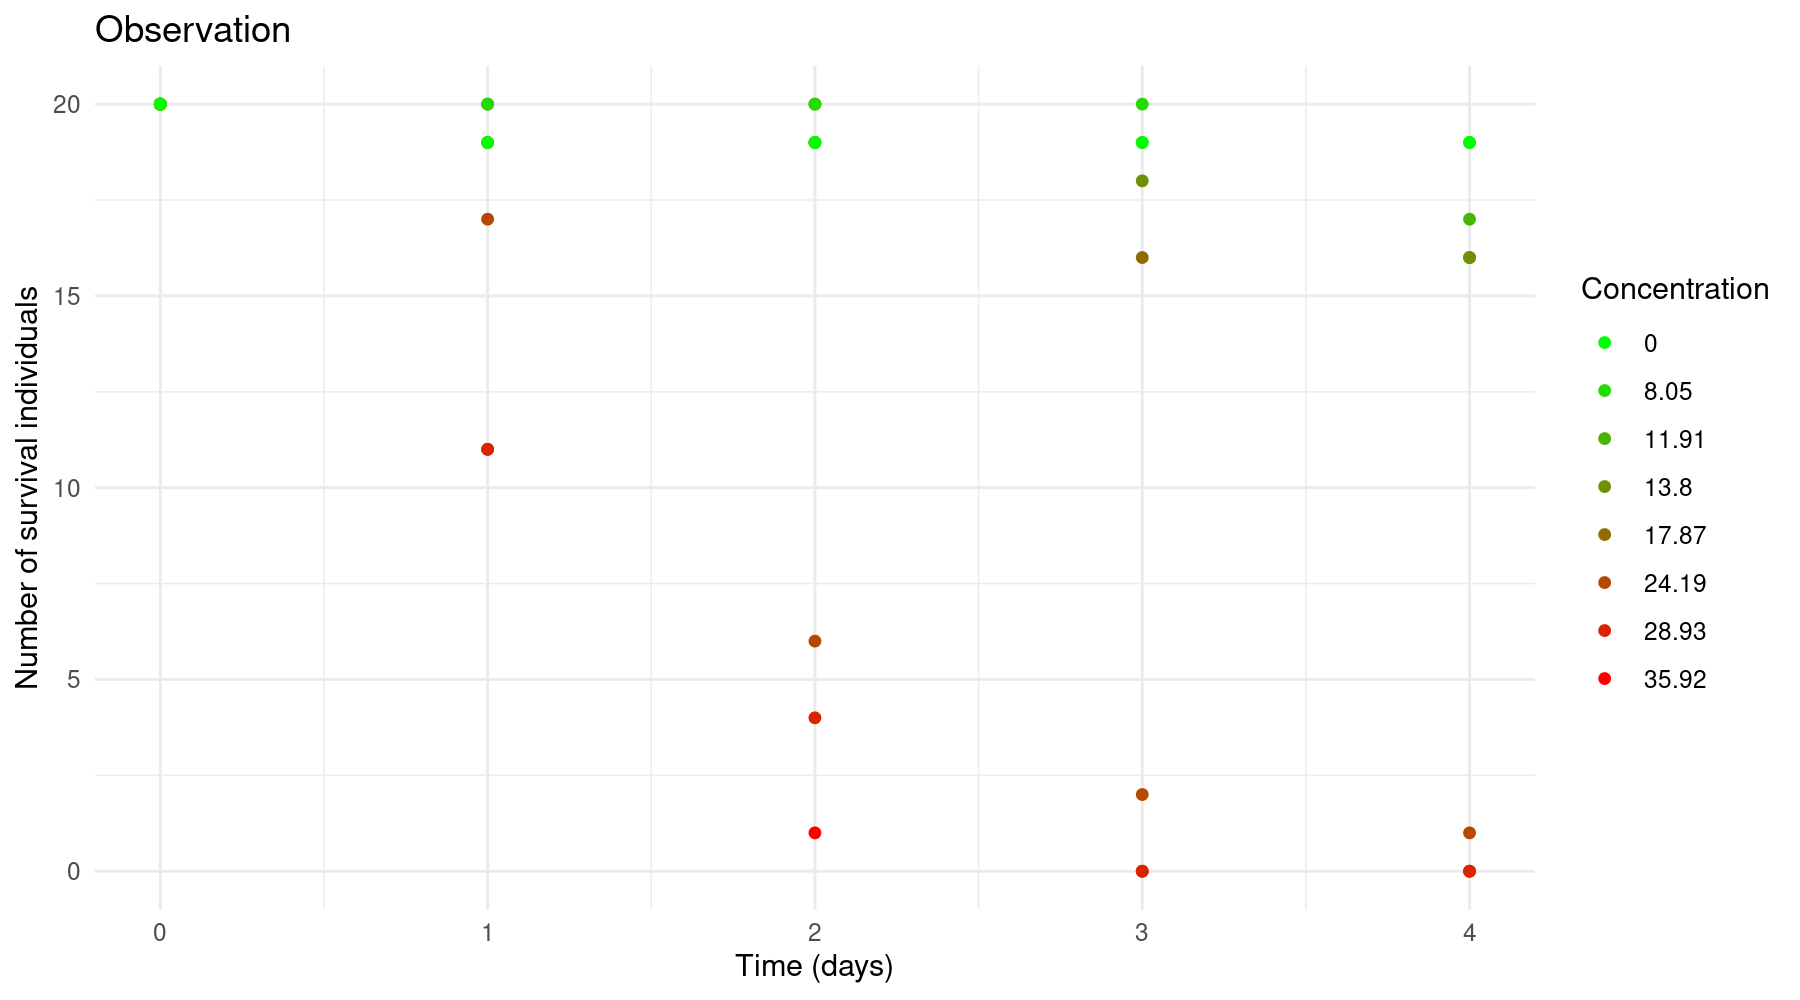

In [27]:
# create a palette of color
pal_GR = colorRampPalette(c("green", "red"))(length(levels(dataGUTS$concentration)))
# plot
ggplot(data = dataGUTS) + 
    theme_minimal() +
    scale_color_manual(values = pal_GR, name = "Concentration") +
    labs(title = "Observation",
         x = "Time (days)",
         y = "Number of survival individuals") +
    geom_point(aes(x = time, y = Nsurv, color = concentration))

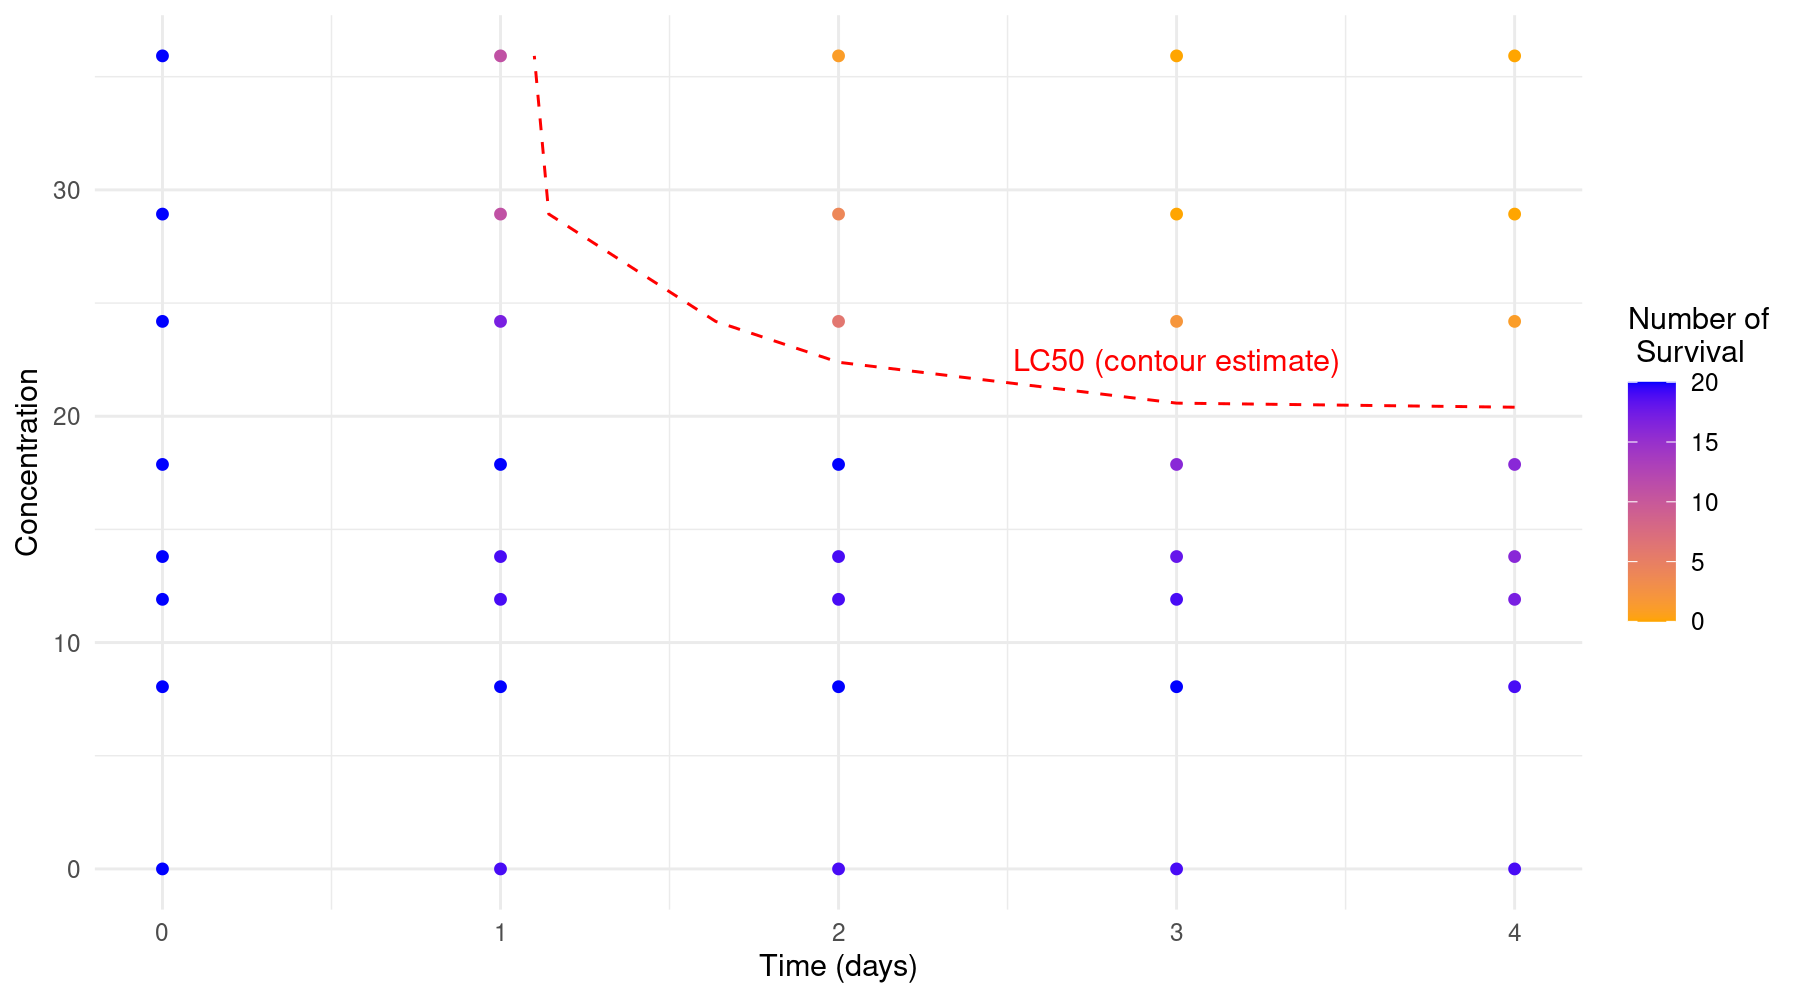

In [28]:
ggplot(data = dataGUTS) + 
    theme_minimal() +
    scale_color_gradient(low = "orange", high = "blue", name = "Number of\n Survival") +
    labs(x = "Time (days)",
         y = "Concentration") +
    geom_point(aes(x=time, y=conc, color = Nsurv)) +
    geom_contour(aes(x=time, y=conc, z = Nsurv), breaks = c(10), color = "red", linetype = "dashed") +
    geom_text(data = data.frame(x = 3, y = 22.5, label = "LC50 (contour estimate)"), aes(x = x, y = y, label = label), color = "red")

### Defining the model

* We denote $N_{survival}$ the random variable counting the number of survival
* We denote $p_{survival}(t,c)$ the probability of survival at time $t$ and concentration $c$
* We denote $LC_{50}(t)$ the lethal concentration for 50% of individuals  at time $t$

1. The random part for counting the number of survival following a Binomial law with parameter $n$, the number of trial (the number of individuals) and $p_{survival}(t,c)$ the probability of survival up to time $t$ under concentration $c$:
$$
N_{survival}^{(t)} \sim \text{Binomial}(N_{survival}^{init}, p_{survival}(t,c)) 
$$

Note: We could have considered a conditional probability of survival between time $t-1$ and $t$ with something looking like:
$
N_{survival}^{(t)} \sim \text{Binomial}\left( N_{survival}^{(t-1)}, \frac{p_{survival}(t,c)}{p_{survival}(t-1,c)} \right) 
$
This is something we have done in the R package `morse` so, we'll see it later.

2. Link functions:
    * the probability of survival depending on time and the dose is then assumed to follow the log-logistic curve
$$
p_{survival}(t,c) = \frac{1}{1+(c / LC_{50}(t))^\beta}
$$
    * the lethal concentration for 50% of individuals given by an exponeneital curve with time:
$$
LC_{50}(t) = LC_{50}^0 \times \exp(- \lambda t)
$$

where $LC_{50}^0$ is the abstract instantaneous lethal concentration for 50% of the population at time $0$.


3. The prior distributions:
    * $\log_{10}(\beta) \sim \text{Uniform}(-2,2)$
    * $\log_{10}(LC_{50}^0) \sim \text{Uniform}(1,3)$ 
    * $\lambda \sim \text{Gamma}(r=1,l=1/1000)$
  
Note: The gamma distribution is a common choice for a prior distribution for $\lambda$. The gamma distribution is conjugate to the exponential distribution, which means that the posterior distribution will also be a gamma distribution. This makes calculations more tractable. The gamma distribution has two parameters.
In JAGS, the law is given by: $\frac{l^r x^{r-1}}{\Gamma(r)}e^{-lx}$, so has the mean is $r/l$ and variance is $r/l^2$. With $r=1$ the distribution is and exponential law with rate $l$. In R, the gamma distribution is given with the shape $\alpha=r$ and the scale $\sigma = 1/l$.

### Implementation

We first have to rewrite the data to add the lag variable $N_{survival}^{(t-1)}$ that we name `Nsurvival_prec`.

In [29]:
Nprec = lapply(unique(dataGUTS$replicate), function(rep){
    N = dataGUTS[dataGUTS$replicate == rep,]$Nsurv
    Nprec = c(N[1],N[-length(N)])
    return(Nprec)
})
dataGUTS$Nsurvival_prec = do.call("c", Nprec)

In [30]:
modelTimeConc <- "model
    {
        # Observed nodes - Link Function
        for (i in 1:n_data){
            Nsurvival[i] ~ dbin(psurvival[i], Nsurvival_predinit)
            psurvival_[i] <- 1/(1+(concentration[i]/LC50[i])^beta)
            # 0 < psurvival < 1
            psurvival[i] <- ifelse(psurvival_[i] >= 1, 1-1e-10,
                    ifelse(psurvival_[i] <= 0 , 1e-10, psurvival_[i]))
            LC50[i] <- LC50_0 * exp(-lambda * time[i])
        }
        # Definition priors        
        log10beta ~ dunif(-2,2)
        beta <- pow(10,log10beta)
        log10LC50_0 ~ dunif(-1,4)
        LC50_0 <- pow(10,log10LC50_0)
        lambda ~ dgamma(1,1/100)

        # Generation of new data
        for(i in 1:n_pred){
            Nsurvival_pred[i] ~ dbin(psurvival_pred[i], Nsurvival_predinit)
            # 0 < psurvival < 1
             psurvival_pred_[i] <- 1/(1+(concentration_pred[i]/LC50_pred[i])^beta)
            psurvival_pred[i] <- ifelse(psurvival_pred_[i] >= 1, 1-1e-10,
                    ifelse(psurvival_pred_[i] <= 0 , 1e-10, psurvival_pred_[i]))
            LC50_pred[i] <- LC50_0 * exp(- lambda * time_pred[i])
            
        }
    }"

In [31]:
seq_merge = function(array, size){
    unique(c(array, seq(min(array), max(array), length.out = size)))
}
data_pred <- expand.grid(
    concentration_pred = seq_merge(dataGUTS$conc, 20),
    time_pred = seq_merge(dataGUTS$time, 5)
)

In [32]:
data4jags_TC <- list(
    n_data = nrow(dataGUTS),
    concentration = dataGUTS$conc,
    time = dataGUTS$time,
    Nsurvival = dataGUTS$Nsurv,
    n_pred = nrow(data_pred),
    concentration_pred = data_pred$concentration_pred,
    time_pred = data_pred$time_pred,
    Nsurvival_predinit = max(dataGUTS$Nsurv)
)

In [33]:
model_TC <- jags.model(
    file = textConnection(modelTimeConc),
    data = data4jags_TC,
    n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 133
   Total graph size: 1585

Initializing model



In [34]:
update(model_TC, 5000)

In [35]:
mcmc_TC <- coda.samples(model_TC, c("Nsurvival_pred"), n.iter = 20000)

In [36]:
matrix_mcmc = extract_chain(mcmc_TC, 'Nsurvival_pred')
prediction = apply(matrix_mcmc, 2, quantile, c(0.05,0.5,0.975))
df_prediction = cbind(data_pred, as.data.frame(t(prediction)))
df_prediction$conc = df_prediction$concentration_pred

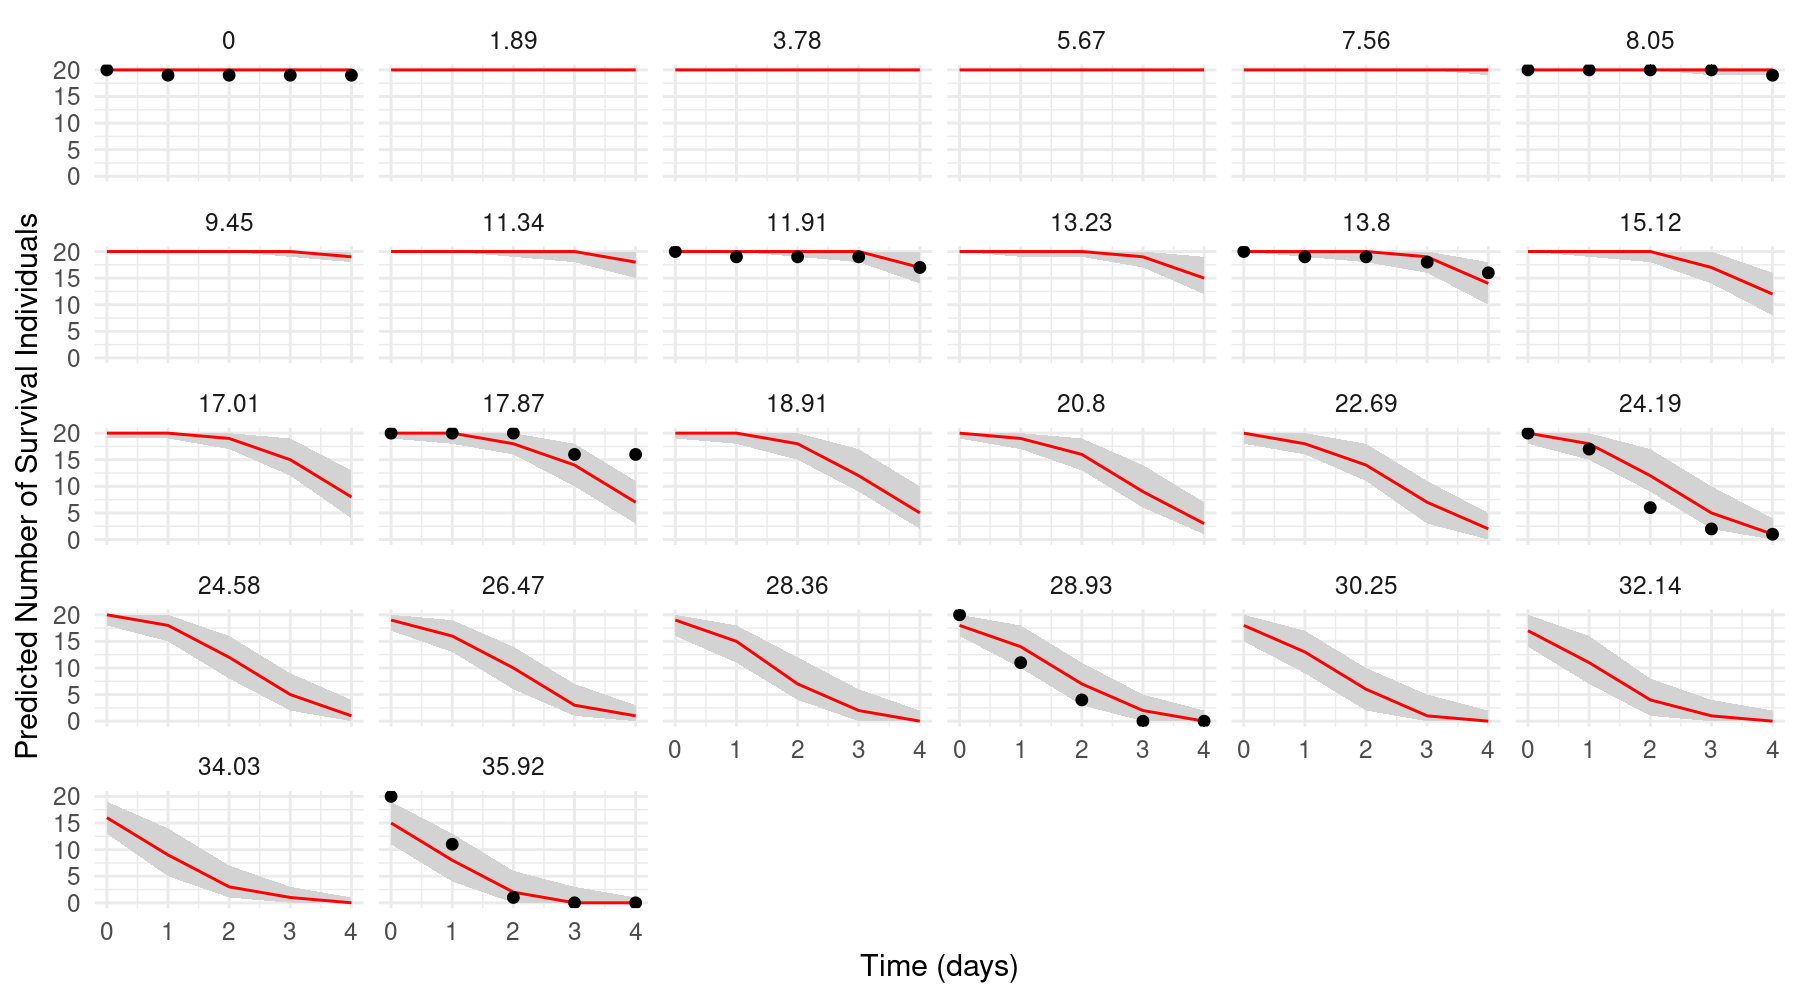

In [37]:
ggplot(data = df_prediction) + 
    theme_minimal() +
    labs( x = "Time (days)", y = "Predicted Number of Survival Individuals") +
    geom_ribbon(aes(x = time_pred, ymin=`5%`, ymax=`97.5%`), fill = "lightgrey") +
    geom_line(aes(x = time_pred, y=`50%`), color = "red") +
    geom_point(data = dataGUTS, aes(x = time, y = Nsurv)) + 
    facet_wrap(~round(conc,2))